#### Compute cyclone center density according to Neu & al (2013) description :
*Percentage of cyclone occurrence per time step and per unit area of (1000 km2). For example, if at a grid location the cyclone center density is 10%, then in an area of 1000 km × 1000 km in 100 time steps we find 10 cyclones. A value >100% means there is more than one cyclone per time step in that area on average (synonymous with cyclone frequency).*

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4

# matplotlib import
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

# cartopy import
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

# scipy import
from scipy.interpolate import griddata
from scipy.ndimage import convolve

In [3]:
def add_features():
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none', edgecolor='black', zorder=6)
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='lightgray', zorder=4)
    
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black', facecolor='none', zorder=7)
    
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black',
                                            facecolor='None',lw=1.2, zorder=9)

    ax.add_feature(land_50m)    
    ax.add_feature(lakes_50m)
    ax.add_feature(lakes_50m_edge)
    ax.add_feature(cfeature.BORDERS, zorder=6, edgecolor='black')  
    ax.add_feature(states_provinces)
    ax.coastlines('50m', zorder=7, color='black',lw=1.2)

### Circular filter around a fixed radius

In [4]:
def circ_krnl(radius) : 
    
    """
    
    Create a kernel (matrix). 
    (0,0) is the pixel of interest
    if (i,j) = 1, the pixel is at r distance from (0,0)
    if (i,j) = 0, the pixel is further.
    
    """
    
    # x, y : horizontal (vertical) 1D array with values from -9 to 9
    y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
    
    # get rid of negative values and get pixels that are within the 
    # radius distance of (0,0)
    mask = x**2 + y**2 <= radius **2
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    
    # Assign 1 to pixel if mask == True and 0 if False
    kernel[~mask] = 0
    return kernel

def circ_filt(array, radius) : 
    
    """
    
    Use convolve scipy function to calculate the average value
    around a grid point (pixel) with a given radius (creates circular smoothing)
    
    """
    kernel = circ_krnl(radius)
    
    # normalize the kernel
    n_krnl = kernel / np.sum(kernel) 
    
    return convolve(array, n_krnl)

## Plot raw cyclone center density like Neu & al. (2013) without smoothing

In [5]:
data = pd.read_csv('/pampa/cloutier/density/NAEC/NAEC_max_season_center_den_each_gp.csv')

Processing ... JJA
Processing ... SON
Processing ... DJF
Processing ... MAM


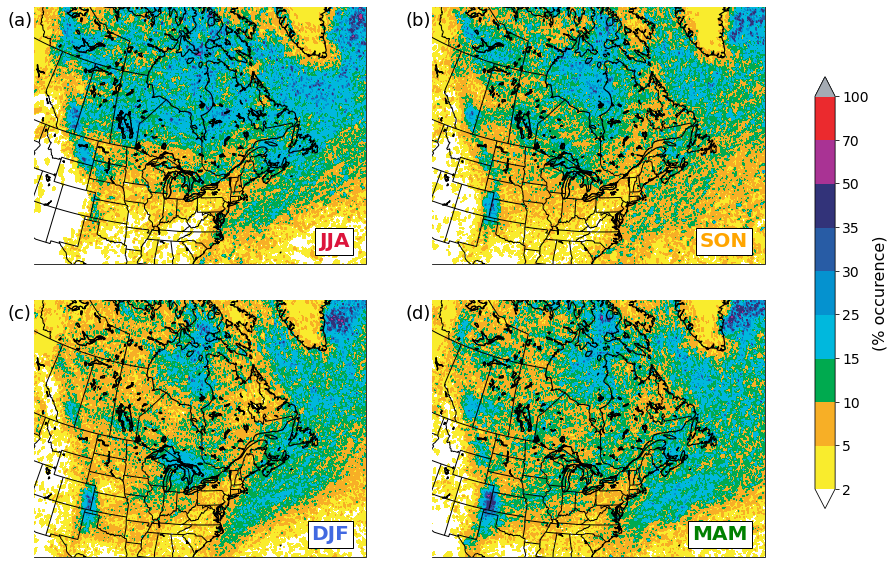

In [14]:
# create lists for iteration
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'green']
index = ['(a)', '(b)', '(c)', '(d)']

i = 1
fig = plt.figure(figsize = (14, 12), facecolor='white')
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])
extent = (-110, -50, 27.5, 67.3)

for szn, col, idx in zip(seasons, colors, index) : 
    
    # iterate through each season
    print('Processing ...', szn)
    df = data.loc[data.season == szn]
    lat = df['latitude']
    lon = df['longitude']
    den = df['storm_count']
    
    # Define the grid for interpolation
    g_x, g_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]
    
    # Perform nearest neighbor interpolation on grid
    den_arr = griddata((lon, lat), den, (g_x, g_y), method='nearest')
    
    # Percentage of cyclone occurence per time step and per 1000km2
    den_area = (den_arr * (1000**2)) / (np.cos(np.radians(g_y)) * (111.3 * 0.25)**2)
    den_per = den_area * 100 / len(df)
    
    # Create the subplot 
    ax = fig.add_subplot(2, 2, i, projection = proj)
    ax.set_extent(extent)
    add_features()
    i += 1 
    
    custom_levels = [2, 5, 10, 15, 25, 30, 35, 50, 70, 100]
    
    colors_cmap = ['white', '#F9EC2D', '#F7AF26', '#00AA4F', '#00B8DD', '#0592CF', 
                   '#285CA5', '#323379', '#A93394', '#EB2A2E', '#A4ABB3']

    contour = ax.contourf(g_x, g_y, den_per, color=col, transform=ccrs.PlateCarree(), 
                          levels = custom_levels, extend='both', zorder=5,colors=colors_cmap)
    
    # Add season text box
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, 
            zorder=16, fontweight='bold', color=col)
    
    # Add index text box
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)
    
# Adjust the positioning of subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace=0.2, right=0.85)

# Create a colorbar next to the figure
# Value 1 : x coordinate (move left and right)
# value 2 : y coordinate (move up and down)
# Value 3 : Width 
# value 4 : height (in terms of % of the figure)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.5])  # Adjust the position and size as needed
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.set_label(label='(% occurence)', size=16)
#fig.text(0.3, 0.82, 'Cyclone center density (Neu & al (2013))', va='top', fontsize=16)
cbar.ax.tick_params(labelsize=14)

#plt.savefig('/pampa/cloutier/fig/cyclone_center_density.png', dpi = 300)

## Plot cyclone center density like Neu & al. (2013) with smoothing

Processing ... JJA


/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Processing ... SON
Processing ... DJF
Processing ... MAM


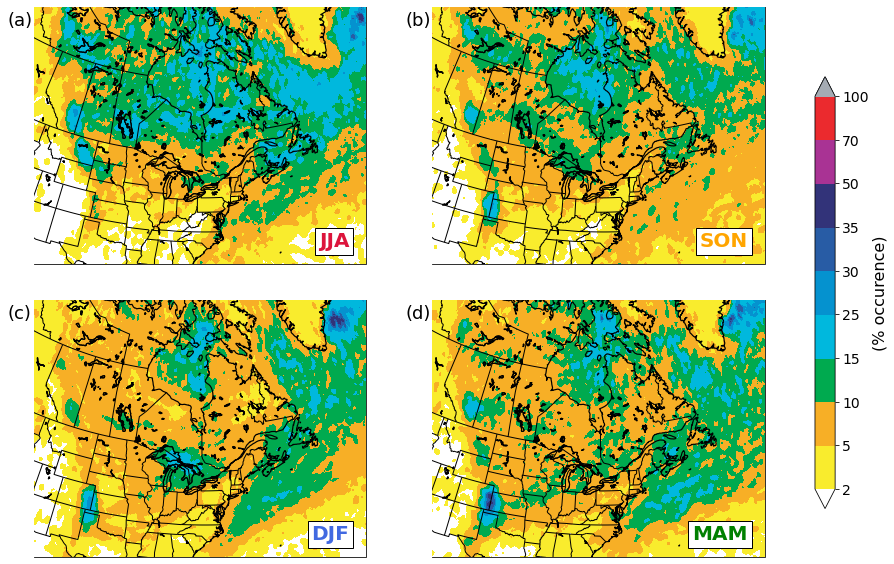

In [6]:
# create lists for iteration
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'green']
index = ['(a)', '(b)', '(c)', '(d)']

i = 1
fig = plt.figure(figsize = (14, 12), facecolor='white')
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])
extent = (-110, -50, 27.5, 67.3)

# Radius expressed in pixels 
r = 2

for szn, col, idx in zip(seasons, colors, index) : 
    
    # iterate through each season
    print('Processing ...', szn)
    df = data.loc[data.season == szn]
    lat = df['latitude']
    lon = df['longitude']
    den = df['storm_count']
    
    # Define the grid for interpolation
    g_x, g_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]
    
    # Perform nearest neighbor interpolation on grid
    den_arr = griddata((lon, lat), den, (g_x, g_y), method='nearest')
    
    # Percentage of cyclone occurence per time step and per 1000km2
    den_area = (den_arr * (1000**2)) / (np.cos(np.radians(g_y)) * (111.3 * 0.25)**2)
    den_per = den_area * 100 / len(df)
    
    # Add smoothing
    den_filt = circ_filt(den_per, r)
    
    # Create the subplot 
    ax = fig.add_subplot(2, 2, i, projection = proj)
    ax.set_extent(extent)
    add_features()
    i += 1 
    
    custom_levels = [2, 5, 10, 15, 25, 30, 35, 50, 70, 100]
    
    colors_cmap = ['white', '#F9EC2D', '#F7AF26', '#00AA4F', '#00B8DD', '#0592CF', 
                   '#285CA5', '#323379', '#A93394', '#EB2A2E', '#A4ABB3']

    contour = ax.contourf(g_x, g_y, den_filt, color=col, transform=ccrs.PlateCarree(), 
                          levels = custom_levels, extend='both', zorder=5,colors=colors_cmap)
    
    # Add season text box
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, 
            zorder=16, fontweight='bold', color=col)
    
    # Add index text box
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)
    
# Adjust the positioning of subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace=0.2, right=0.85)

# Create a colorbar next to the figure
# Value 1 : x coordinate (move left and right)
# value 2 : y coordinate (move up and down)
# Value 3 : Width 
# value 4 : height (in terms of % of the figure)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.5])  # Adjust the position and size as needed
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.set_label(label='(% occurence)', size=16)
#fig.text(0.35, 0.82, 'Cyclone center density (Neu & al (2013))', va='top', fontsize=16)
cbar.ax.tick_params(labelsize=14)

#plt.savefig('/pampa/cloutier/fig/cyclone_center_density_smooth.png', dpi = 300)

#### For DJF only

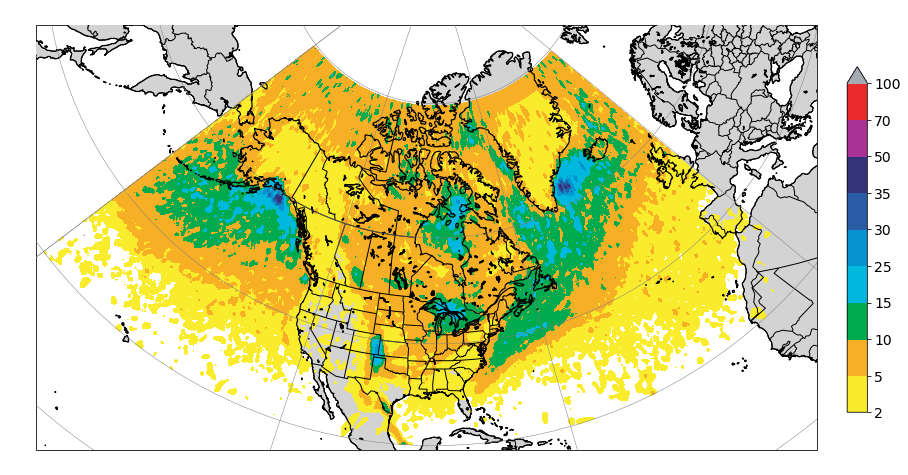

In [10]:
fig = plt.figure(figsize = (14, 12))
proj = ccrs.LambertConformal(central_longitude=-88, central_latitude=53, standard_parallels=[35])
extent = (-165, -15, 5, 80)
i = 1
# Radius expressed in pixels 
r = 2

df = data.loc[data.season == 'DJF']
lat = df['latitude']
lon = df['longitude']
den = df['storm_count']

# Define the grid for interpolation
g_x, g_y = np.mgrid[lon.min():lon.max():0.25, lat.min():lat.max():0.25]

# Perform nearest neighbor interpolation on grid
den_arr = griddata((lon, lat), den, (g_x, g_y), method='nearest')

# Percentage of cyclone occurence per time step and per 1000km2
den_area = (den_arr * (1000**2)) / (np.cos(np.radians(g_y)) * (111.3 * 0.25)**2)
den_per = den_area * 100 / len(df)

# Add smoothing
den_filt = circ_filt(den_per, r)

# Create the subplot 
ax = fig.add_subplot(1, 1, 1, projection = proj)
ax.set_extent(extent)
add_features()
i += 1 

custom_levels = [2, 5, 10, 15, 25, 30, 35, 50, 70, 100]

colors_cmap = ['#F9EC2D', '#F7AF26', '#00AA4F', '#00B8DD', '#0592CF', 
               '#285CA5', '#323379', '#A93394', '#EB2A2E', '#A4ABB3']

contour = ax.contourf(g_x, g_y, den_filt, transform=ccrs.PlateCarree(), 
                      levels = custom_levels, extend='max', zorder=5,colors=colors_cmap)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                  x_inline=False, y_inline=False, zorder=10)

# Change font color to white
gl.xlabel_style = {'color': 'white'}
gl.ylabel_style = {'color': 'white'}


# Create a colorbar next to the figure
# Value 1 : x coordinate (move left and right)
# value 2 : y coordinate (move up and down)
# Value 3 : Width 
# value 4 : height (in terms of % of the figure)
cbar_ax = fig.add_axes([0.93, 0.3, 0.02, 0.4]) 
cbar = fig.colorbar(contour, cax=cbar_ax)

#cbar.set_label(label='(% occurence)', size=16)
#fig.text(0.35, 0.82, 'Cyclone center density (Neu & al (2013))', va='top', fontsize=16)
cbar.ax.tick_params(labelsize=14)

#plt.savefig('/pampa/cloutier/fig/cyclone_center_density_smooth_DJF.png', dpi=300, bbox_inches='tight', figsize=(14,12))